In [1]:
import json 
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

from collections import defaultdict
from tqdm import tqdm


In [2]:
from networkx.readwrite import json_graph
import json

l = 153
G_t  = []

for i in range(l):
    with open('datasets/sourcecred/makerDao_work/wg'+str(i)+'.json', 'r') as f:
        d = json.loads(f.read())
        G = json_graph.node_link_graph(d)
        # Normalize the weights to [1, inf]
        for e in list(G.edges()):
            G[e[0]][e[1]]['weight'] *= 4
        G_t.append(G)

id_to_user = {}
with open('datasets/sourcecred/md_users.txt', 'r') as outfile1:
    vals = outfile1.read()
    for v in vals.split('\n'):
        vals_s = v.split(',')
        if len(vals_s) == 2:
            id_to_user[vals_s[0]] = vals_s[1]    


# Sybil Attack on MakerDAO contribution graph

Two types of attacks: (1) Passive Attack and (2) Active Attack. 

We illustrate that the most prominent reputation functions are vulnerable to Sybil attacks, either Passive or Active. 

In [3]:
# Personalized PageRank 
# Personalized Hitting Time 
# Personalized MaxFlow
# MeritRank

from trust.pagerank import PersonalizedPageRank, PersonalizedPageRankNx, BoundedPPR
from trust.hitting_time import PersonalizedHittingTime
from trust.maxflow_based import MaxFlow, BarterCast

from trust.seed_choice import get_seed_rep_max

import pandas as pd

In [4]:
def normalize(rep_vals):
    """Normalize reputation values to [0, 1]."""
    max_rep = sum(rep_vals.values())
    new_vals = {}
    for v in rep_vals:
        new_vals[v] = rep_vals[v] / max_rep
    return new_vals

def build_aux_graph(G, seed_node):
    H = G.copy()
    for e in G.edges():
        if e[0] != seed_node:
            H[e[0]][e[1]]['weight'] = G[e[0]][e[1]]['weight'] / G.out_degree(e[0], weight='weight')
    return H

def decay_aux_graph(G, seed_node, p=0.85):
    lvl = 0
    cur_s = {seed_node}
    next_s = set()
    for f,t,_ in nx.edge_bfs(G, seed_node, orientation='original'):
        if f in cur_s:
            next_s.add(t)
            G[f][t]['weight'] *= p**lvl
        else:
            # Start of new level 
            lvl += 1
            cur_s = next_s.copy()
            next_s = {t}
            G[f][t]['weight'] *= p**lvl
    return G

def aux_max_flow(G, seed_node, rep_vals, decay_p = 0.85):
    T = build_aux_graph(G, -1)
    T = decay_aux_graph(T, seed_node, decay_p)
    for i in T.nodes():
        if i != seed_node:
            rep_vals[i] += nx.maximum_flow_value(T, seed_node, i, capacity='weight')

def simple_maxflow(G, seed_node, rep_vals, **kwargs):
    for i in G.nodes():
        if i != seed_node:
            rep_vals[i] += nx.maximum_flow_value(G, seed_node, i, capacity='weight')


def simple_pht(G, seed_node, rep_vals, decay_p: float, use_weight: bool = False):
    pht = PersonalizedHittingTime(G, seed_node, reset_probability=1-decay_p)
    weight_mult = G.out_degree(seed_node, weight='weight') if use_weight else 1.0
    for i in G.nodes():
        if i != seed_node:
            rep_vals[i] += weight_mult * pht.compute(seed_node, i)


def simple_ppr(G, seed_node, rep_vals, decay_p: float, use_weight: bool = False):
    pht = PersonalizedPageRank(G, seed_node, reset_probability=1-decay_p)
    weight_mult = G.out_degree(seed_node, weight='weight') if use_weight else 1.0
    for i in G.nodes():
        if i != seed_node:
            rep_vals[i] += weight_mult *  pht.compute(seed_node, i)

def reputation_cut(G, s, rand, vals, gamma=0.95, threshold = 1.0, with_condition=False):
    res_vals = {}
    for g in G.nodes():
        max_neck = max(rand.coleadings[g].values()) if rand.coleadings[g] else 0
        full_condition = max_neck > 0 and (not with_condition 
                                           or max_neck >= threshold*rand.get_number_of_hits(s, g))
        if full_condition:
            rw_prop = max_neck / rand.get_number_of_hits(s, g)
            res_vals[g] = max(vals[g] *gamma*rw_prop, 0)
    new_res = {}
    all_sum = sum(vals[k]-res_vals[k] for k in res_vals.keys())
    if all_sum == 1:
        print('All edges are cut!')
    else:
        mult = 1/ (1- all_sum)
        for k in set(vals.keys()) - set(res_vals.keys()):
            new_res[k] = vals[k] * mult
    for k in res_vals:
        new_res[k] = res_vals[k]
    return new_res


def rep_with_cut(G, seed_node, rep_vals, rep_alg, theta: float = 1.0, 
                 gamma: float = 0.95, threshold = 1.0, with_condition=True):
    vals = {}
    for i in G.nodes():
        if i != seed_node:
            vals[i] = rep_alg.compute(seed_node, i)
    new_vals = reputation_cut(G, seed_node, 
                              rep_alg.random_walks, vals, 
                              gamma, threshold, with_condition) 
    for k,v in new_vals.items():
        rep_vals[k] += v 

def pht_cut(G, seed_node, rep_vals, decay_p, theta: float = 1.0, gamma=0.95, threshold = 1.0, with_condition=True):
    rep_alg = PersonalizedHittingTime(G, seed_node, 1000, reset_probability=1-decay_p)
    rep_with_cut(G, seed_node, rep_vals, rep_alg, theta, gamma, threshold, with_condition)

def ppr_cut(G, seed_node, rep_vals, decay_p, theta: float = 1.0,  gamma=0.95, threshold = 1.0, with_condition=True):
    rep_alg = PersonalizedPageRank(G, seed_node, 1000, reset_probability=1-decay_p)
    rep_with_cut(G, seed_node, rep_vals, rep_alg, theta, gamma, threshold, with_condition)

def pmf_cut(G, seed_node, rep_vals, decay_p, theta: float = 1.0,  gamma=0.95, threshold = 1.0, with_condition=True):
    T = build_aux_graph(G, -1)
    T = decay_aux_graph(T, seed_node, decay_p)
    vals = {}
    for i in T.nodes():
        if i != seed_node:
            vals[i] = nx.maximum_flow_value(T, seed_node, i, capacity='weight')
    for k,v in vals.items():
        rep_vals[k] +=  v
    


In [5]:
def pick_seeds(new_seeds, num_seeds):
    cur_seeds = []
    selected_seeds = 0
    while selected_seeds < num_seeds:
        for s in new_seeds:
            if s in G and G.out_degree(s) > 0:
                cur_seeds.append(s)
                selected_seeds += 1
                if selected_seeds == num_seeds:
                    return cur_seeds
        if selected_seeds != num_seeds:
            print('Cannot find enough seeds!')
            print(new_seeds)
            return None
    
def agg_rep_update(G: nx.Graph, seed_node: int, rep_alg, **rep_params):
    """Update reputation values based on the accumulated reputation."""
    new_rep = {}
    rep = rep_alg(G, seed_node, **rep_params)
    for v_node in G.nodes():
        if v_node != seed_node:
            new_rep[v_node] = rep.compute(seed_node, v_node)
    return new_rep


attack_w = 10
num_syb = 5

attack_w = 20
max_l = 80

def add_sybil_path_region(G, attacker_node, total_syb, num_syb):
    G.add_edge(attacker_node, attacker_node*2 + total_syb, weight=attack_w)
    a = attacker_node*2 + total_syb
    for i in range(num_syb):
        G.add_edge(a + i, a + i + 1, weight=attack_w)
    return num_syb + 1

def add_sybil_cycle_region(G, attacker_node, total_syb, num_syb):
    for i in range(num_syb):
        a = attacker_node*2 + total_syb + i
        G.add_edge(attacker_node, a, weight=attack_w)
        G.add_edge(a, attacker_node, weight=attack_w)
    return num_syb

def add_sybil_parallel_region(G, attacker_node, total_syb, num_syb):
    a = attacker_node*2 + total_syb
    for i in range(num_syb):
        G.add_edge(attacker_node, a + i, weight=attack_w)
    return num_syb + 1



In [7]:
df = pd.DataFrame()
attack_stratgies = {'cycle': add_sybil_cycle_region, 
                    'path': add_sybil_path_region, 
                    'parallel': add_sybil_parallel_region}

alg_func = {'pht': pht_cut, 'ppr': ppr_cut, 'pmf': pmf_cut}
optimal_attacks = {'pht': 'path', 'ppr': 'cycle'}

In [31]:
df2 = pd.DataFrame()

In [36]:
# Total time
end_w = 50
eps = 10**(-5)

# Sybil attack params
attack_w = 20
id_shift = 0
num_syb = 0
attacker_node = 141429
rewards = defaultdict(float)
total_syb = 0

num_seed_connections = 10

# 'pht', 'ppr'
for rep_alg in ['ppr']:    
    for decay_p in [0.99, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.05]:
        for theta in [1.0]:
            for gamma in tqdm([1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.05, 0]):
                for num_syb in [50]:
                    # 0. Select initial seeds: Boostrap Period
                    G = G_t[0].copy()
                    score  = {i: G.in_degree(i, weight='weight') for i in G.nodes()}
                    for k,v in score.items():
                        G.add_edge(0, k, weight=v)
                    # Reputation and Data Values
                    seed_node = 0
                    rep_vals = defaultdict(float)
                    gains = []
                    for w in range(end_w):
                        # 3. Add sybils
                        if w >= attack_w:
                            total_syb = add_sybil_path_region(G, attacker_node, id_shift, num_syb)
                            add_sybil_cycle_region(G, attacker_node, id_shift, num_syb)
                        # 4. Calculate the reputation with all decays 
                        rep_alg_func = alg_func[rep_alg]
                        rep_alg_func(G, seed_node, rep_vals, decay_p, theta, gamma)
                        # Calculate gain
                        score = {k:v for k,v in rep_vals.items() if v > eps}
                        if w >= attack_w:
                            if score.get(attacker_node):
                                gain = sum(score.get(attacker_node*2+i, 0) for i in range(total_syb)) / score.get(attacker_node)
                            else:
                                gain = 0
                            gains.append(gain)
                        # Add new edges to the graph
                        for f,t,data in G_t[w].edges(data=True):
                            if (f,t) in G.edges():
                                G[f][t]['weight'] += data['weight']
                            else:
                                G.add_edge(f, t, weight=data['weight'])
                        # Update the seed connections 
                        selected_seed_connections = sorted(score.items(), key=lambda x: x[1], reverse=True)[:num_seed_connections]
                        for k,v in selected_seed_connections:
                            G.add_edge(0, k, weight=v)                        
                    i_25 = int(len(gains) * 0.25)
                    i_50 = int(len(gains) * 0.5)
                    i_75 = int(len(gains) * 0.75)
                    i_100 = int(len(gains) - 1)
                    df2 = df2.append({'num_syb': num_syb, 
                            'gain_0':  gains[0], 
                            'gain_25': gains[i_25], 
                            'gain_50': gains[i_50], 
                            'gain_75': gains[i_75],
                            'gain_100': gains[i_100], 
                            'alpha': (1-decay_p),
                            'theta': 1-theta,
                            'gamma': 1-gamma,
                            'rep_alg': rep_alg,
                            }, ignore_index=True)
    
# Epoch Decay: theta


100%|██████████| 12/12 [00:03<00:00,  3.59it/s]


In [148]:
z = df2['gain_100'].to_numpy()
x = df2['alpha'].to_numpy()
y = df2['gamma'].to_numpy()

In [23]:
import seaborn as sns
def set_style():
    # This sets reasonable defaults for font size for
    # a figure that will go in a paper
    sns.set_context("paper")
    
    # Set the font to be serif, rather than sans
    sns.set(font='serif', rc={'figure.figsize': (16,10) }, font_scale=2.66)
    
    # Make the background white, and specify the
    # specific font family
    sns.set_style("ticks", {
        "font.size": 10,
        "font.family": "serif",
        "font.serif": ["Times", "Palatino", "serif"]
    })
    
set_style()

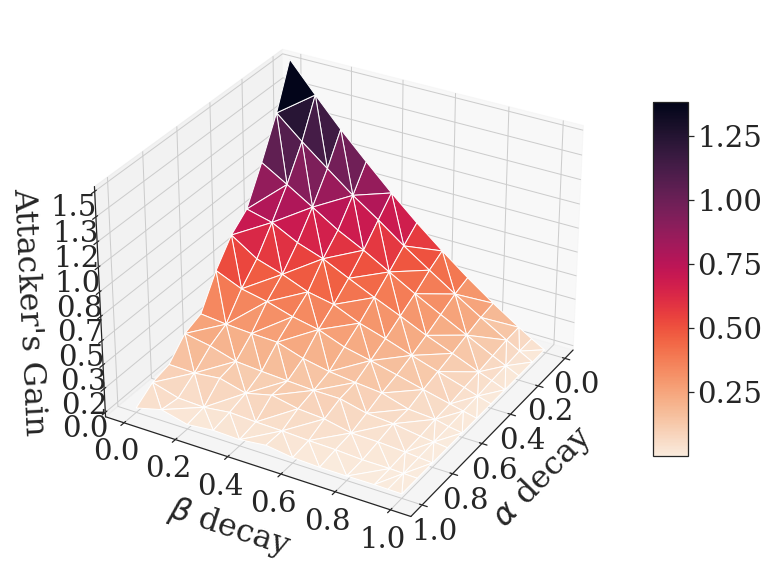

In [152]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})


#x = np.linspace(-4*np.pi,4*np.pi,50)
#y = np.linspace(-4*np.pi,4*np.pi,50)
# = x**2 + y**2

# Plot the surface.
surf = ax.plot_trisurf(x, y, z,  cmap='rocket_r',)

# Customize the z axis.
ax.set_zlim(0, 1.5)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.1f}')
# Add a color bar which maps values to colors.
fig.colorbar(surf,shrink=0.65, aspect=10)
ax.view_init(30, 30)


# Set label for x-axis 
ax.set_xlabel( "\n" +  "$\\alpha$ decay", linespacing=2) 
# Set label for y-axis 
ax.set_ylabel( "\n" +  "$\\beta$ decay", linespacing=2) 
ax.yaxis.set_label_coords(.9, .1)
ax.set_zlabel( "\n" +  "Attacker's Gain", linespacing=2) 
plt.savefig('alpha_beta_cumm.pdf', dpi=500, bbox_inches='tight');
plt.show()


In [351]:
# Total time
end_w = 50
eps = 10**(-5)

# Sybil attack params
attack_w = 20
id_shift = 0
num_syb = 0
attacker_node = 141429
rewards = defaultdict(float)
total_syb = 0

num_seed_connections = 10

# 'pht', 'ppr'
for rep_alg in ['ppr', 'pht']:    
    for decay_p in [0.99]:
        for theta in [1.0]:
            for gamma in [1.0, 0.5, 0.1, 0]:
                for num_syb in [1, 5, 10, 25]:
                    # 0. Select initial seeds: Boostrap Period
                    G = G_t[0].copy()
                    score  = {i: G.in_degree(i, weight='weight') for i in G.nodes()}
                    for k,v in score.items():
                        G.add_edge(0, k, weight=v)
                    # Reputation and Data Values
                    seed_node = 0
                    rep_vals = defaultdict(float)
                    gains = []
                    for w in range(end_w):
                        # 3. Add sybils
                        if w >= attack_w:
                            total_syb = add_sybil_path_region(G, attacker_node, id_shift, num_syb)
                            add_sybil_cycle_region(G, attacker_node, id_shift, num_syb)
                        # 4. Calculate the reputation with all decays 
                        rep_alg_func = alg_func[rep_alg]
                        rep_alg_func(G, seed_node, rep_vals, decay_p, theta, gamma)
                        # Calculate gain
                        score = {k:v for k,v in rep_vals.items() if v > eps}
                        if w >= attack_w:
                            if score.get(attacker_node):
                                gain = sum(score.get(attacker_node*2+i, 0) for i in range(total_syb)) / score.get(attacker_node)
                            else:
                                gain = 0
                            gains.append(gain)
                        # Add new edges to the graph
                        for f,t,data in G_t[w].edges(data=True):
                            if (f,t) in G.edges():
                                G[f][t]['weight'] += data['weight']
                            else:
                                G.add_edge(f, t, weight=data['weight'])
                        # Update the seed connections 
                        selected_seed_connections = sorted(score.items(), key=lambda x: x[1], reverse=True)[:num_seed_connections]
                        for k,v in selected_seed_connections:
                            G.add_edge(0, k, weight=v)                        
                    i_25 = int(len(gains) * 0.25)
                    i_50 = int(len(gains) * 0.5)
                    i_75 = int(len(gains) * 0.75)
                    i_100 = int(len(gains) - 1)
                    df2 = df2.append({'num_syb': num_syb, 
                            'gain_0':  gains[0], 
                            'gain_25': gains[i_25], 
                            'gain_50': gains[i_50], 
                            'gain_75': gains[i_75],
                            'gain_100': gains[i_100], 
                            'alpha': (1-decay_p),
                            'theta': 1-theta,
                            'gamma': 1-gamma,
                            'rep_alg': rep_alg,
                            }, ignore_index=True)
                print('Finished with {}'.format(decay_p))
            print('Finished with {}'.format(gamma))
        print('Finished with {}'.format(theta))
    print('Finished with {}'.format(rep_alg))
    
# Epoch Decay: theta


Finished with 0.99
Finished with 0.99
Finished with 0.99
Finished with 0.99
Finished with 0
Finished with 1.0
Finished with ppr
Finished with 0.99
Finished with 0.99
Finished with 0.99
Finished with 0.99
Finished with 0
Finished with 1.0
Finished with pht


In [353]:
df2.to_csv('clean_gamma_expr.csv')

In [350]:
df2.to_csv('pure_gamma_exper')

,num_syb,gain_0,gain_25,gain_50,gain_75,gain_100,alpha,theta,gamma,rep_alg
0,50.0,0.520605,1.370996,1.523056,1.553984,1.549583,0.01,0.0,0.0,ppr
1,50.0,0.243323,0.567970,0.626091,0.641480,0.646692,0.01,0.0,0.5,ppr
2,50.0,0.044045,0.093794,0.102675,0.105830,0.107595,0.01,0.0,0.9,ppr
3,50.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.01,0.0,1.0,ppr
4,50.0,0.660086,4.049891,6.187606,7.149197,7.529863,0.01,0.0,0.0,pht
5,50.0,0.317676,1.845106,2.719082,3.082396,3.233015,0.01,0.0,0.5,pht
6,50.0,0.062554,0.330276,0.466813,0.522196,0.548428,0.01,0.0,0.9,pht
7,50.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.01,0.0,1.0,pht
8,50.0,0.511028,1.362691,1.519738,1.547995,1.544619,0.01,0.0,0.0,ppr
9,50.0,0.245467,0.572243,0.628362,0.643576,0.648121,0.01,0.0,0.5,ppr


In [344]:
# Total time
end_w = 50
eps = 10**(-5)

# Sybil attack params
attack_w = 20
id_shift = 0
num_syb = 0
attacker_node = 141429
rewards = defaultdict(float)
total_syb = 0

num_seed_connections = 10

# 'pht', 'ppr'
for rep_alg in ['ppr', 'pht']:    
    for decay_p in [0.8, 0.2]:
        for theta in [1.0, 0.5, 0.25, 0.1, 0]:
            for gamma in [1.0]:
                for num_syb in [50]:
                    # 0. Select initial seeds: Boostrap Period
                    G = G_t[0].copy()
                    score  = {i: G.in_degree(i, weight='weight') for i in G.nodes()}
                    for k,v in score.items():
                        G.add_edge(0, k, weight=v)
                    # Reputation and Data Values
                    seed_node = 0
                    rep_vals = defaultdict(float)
                    gains = []
                    for w in range(end_w):
                        # 3. Add sybils
                        if w >= attack_w:
                            total_syb = add_sybil_path_region(G, attacker_node, id_shift, num_syb)
                            add_sybil_cycle_region(G, attacker_node, id_shift, num_syb)
                        rep_vals_round = defaultdict(float)
                        # 4. Calculate the reputation with all decays 
                        rep_alg_func = alg_func[rep_alg]
                        rep_alg_func(G, seed_node, rep_vals_round, decay_p, theta, gamma)
                        for k,v in rep_vals_round.items():
                            rep_vals[k] = rep_vals[k]*theta + v
                        # Calculate score with theta decay.
                        score = {k:v for k,v in rep_vals.items() if v > eps}
                        if w >= attack_w:
                            if score.get(attacker_node):
                                gain = sum(score.get(attacker_node*2+i, 0) for i in range(total_syb)) / score.get(attacker_node)
                            else:
                                gain = 0
                            gains.append(gain)
                        # Add new edges to the graph
                        for f,t,data in G_t[w].edges(data=True):
                            if (f,t) in G.edges():
                                G[f][t]['weight'] += data['weight']
                            else:
                                G.add_edge(f, t, weight=data['weight'])
                        # Update the seed connections 
                        G.remove_node(0)
                        selected_seed_connections = sorted(score.items(), key=lambda x: x[1], reverse=True)[:num_seed_connections]
                        for k,v in selected_seed_connections:
                            G.add_edge(0, k, weight=v)                        
                    i_25 = int(len(gains) * 0.25)
                    i_50 = int(len(gains) * 0.5)
                    i_75 = int(len(gains) * 0.75)
                    i_100 = int(len(gains) - 1)
                    df2 = df2.append({'num_syb': num_syb, 
                            'gain_0':  gains[0], 
                            'gain_25': gains[i_25], 
                            'gain_50': gains[i_50], 
                            'gain_75': gains[i_75],
                            'gain_100': gains[i_100], 
                            'alpha': (1-decay_p),
                            'theta': 1-theta,
                            'gamma': 1-gamma,
                            'rep_alg': rep_alg,
                            }, ignore_index=True)
                print('Finished with gamma {}'.format(gamma))
            print('Finished with theta {}'.format(theta))
        print('Finished with alpha {}'.format(decay_p))
    print('Finished with {}'.format(rep_alg))
# Epoch Decay: theta


Finished with gamma 1.0
Finished with theta 1.0
Finished with gamma 1.0
Finished with theta 0.5
Finished with gamma 1.0
Finished with theta 0.25
Finished with gamma 1.0
Finished with theta 0.1
Finished with gamma 1.0
Finished with theta 0
Finished with alpha 0.8
Finished with gamma 1.0
Finished with theta 1.0
Finished with gamma 1.0
Finished with theta 0.5
Finished with gamma 1.0
Finished with theta 0.25
Finished with gamma 1.0
Finished with theta 0.1
Finished with gamma 1.0
Finished with theta 0
Finished with alpha 0.2
Finished with ppr
Finished with gamma 1.0
Finished with theta 1.0
Finished with gamma 1.0
Finished with theta 0.5
Finished with gamma 1.0
Finished with theta 0.25
Finished with gamma 1.0
Finished with theta 0.1
Finished with gamma 1.0
Finished with theta 0
Finished with alpha 0.8
Finished with gamma 1.0
Finished with theta 1.0
Finished with gamma 1.0
Finished with theta 0.5
Finished with gamma 1.0
Finished with theta 0.25
Finished with gamma 1.0
Finished with theta 0.1


In [346]:
df2.to_csv('theta_graph_seeds_10.csv')

In [342]:
df2.to_csv('theta_graph_all_seeds.csv')

In [338]:
df2.to_csv('theta_weights_all_seeds.csv')

In [330]:
df2.to_csv('theta_vals_weights.csv')

In [325]:
df2.to_csv('theta_weights_10_seeds.csv')

In [318]:
df2.to_csv("rep_alg.csv")

In [289]:
df = pd.DataFrame()

In [290]:
# Total time
end_w = 50
eps = 10**(-5)

cut_eps = 0.25

num_seed_connections = 10

# Reputation and Data Values
seed_node = 0

for rep_alg in ['pht']: 
    for num_syb in [1, 25, 50]:
        for theta in [1.0, 0.5, 0.1, 0]:
            for decay_p in [0.5]: 
                for gamma in [0.5]:
                    rep_vals = defaultdict(float)
                    total_w_value = defaultdict(float)
                    # Calculate ground truth values 
                    gains = []
                    G = G_t[0].copy()
                    score  = {i: G.in_degree(i, weight='weight') for i in G.nodes()}
                    for w in range(end_w):
                        # Calculate the reputation with all decays 
                        G = G_t[w].copy()
                        # Add sybils if required 
                        # 3. Add sybils
                        if w >= attack_w:
                            total_syb = add_sybil_path_region(G, attacker_node, id_shift, num_syb)
                            add_sybil_cycle_region(G, attacker_node, id_shift, num_syb)
                        # Update the seed connections 
                        decayed_score = score if w == 0 else total_w_value
                        selected_seed_connections = sorted(decayed_score.items(), key=lambda x: x[1], reverse=True)
                        for k,v in selected_seed_connections:
                            G.add_edge(0, k, weight=v) 
                        rep_alg_func = alg_func[rep_alg]
                        rep_alg_func(G, seed_node, rep_vals, decay_p, theta, gamma)
                        # Calculate gain
                        score = {k:v for k,v in rep_vals.items()}
                        # Epoch decay mechanics
                        for k,v in total_w_value.items():
                            total_w_value[k] *= theta
                            if total_w_value[k] < eps:
                                total_w_value[k] = 0
                        for k,v in score.items():
                            total_w_value[k] += v
                        if w >= attack_w:
                            if score.get(attacker_node):
                                gain = sum(score.get(attacker_node*2+i, 0) for i in range(total_syb)) / score.get(attacker_node)
                            else:
                                gain = 0
                            gains.append(gain)
                    i_25 = int(len(gains) * 0.25)
                    i_50 = int(len(gains) * 0.5)
                    i_75 = int(len(gains) * 0.75)
                    i_100 = int(len(gains) - 1)
                    df = df.append({'num_syb': num_syb, 
                            'gain_0':  gains[0], 
                            'gain_25': gains[i_25], 
                            'gain_50': gains[i_50], 
                            'gain_75': gains[i_75],
                            'gain_100': gains[i_100], 
                            'alpha': (1-decay_p),
                            'theta': 1-theta,
                            'gamma': 1-gamma,
                            'rep_alg': rep_alg,
                            }, ignore_index=True)
                        

In [291]:
df

,num_syb,gain_0,gain_25,gain_50,gain_75,gain_100,alpha,theta,gamma,rep_alg
0,1.0,0.035096,0.102959,0.178213,0.224463,0.266423,0.5,0.0,0.5,pht
1,1.0,0.030202,0.183953,0.296447,0.367535,0.402437,0.5,0.5,0.5,pht
2,1.0,0.026289,0.167824,0.262590,0.335639,0.373974,0.5,0.9,0.5,pht
3,1.0,0.030740,0.179852,0.266750,0.352887,0.394651,0.5,1.0,0.5,pht
4,25.0,0.076436,0.176880,0.249033,0.301192,0.336652,0.5,0.0,0.5,pht
5,25.0,0.050546,0.193918,0.296736,0.372509,0.440775,0.5,0.5,0.5,pht
6,25.0,0.050548,0.175940,0.313402,0.402138,0.449853,0.5,0.9,0.5,pht
7,25.0,0.055901,0.209583,0.323292,0.429285,0.490933,0.5,1.0,0.5,pht
8,50.0,0.056552,0.148644,0.240676,0.286772,0.326205,0.5,0.0,0.5,pht
9,50.0,0.053950,0.173824,0.257328,0.327910,0.383803,0.5,0.5,0.5,pht


<AxesSubplot:xlabel='num_syb', ylabel='gain_100'>

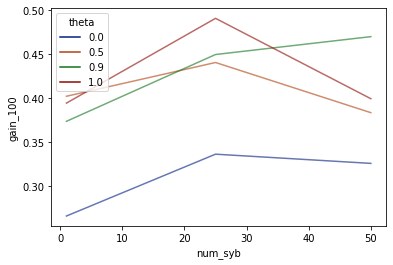

In [292]:
import seaborn as sns
sns.lineplot(x='num_syb', y='gain_100', data=df, hue='theta', palette="dark", alpha=.6)

In [286]:
df

,num_syb,gain_0,gain_25,gain_50,gain_75,gain_100,alpha,theta,gamma,rep_alg
0,1.0,0.037807,0.103122,0.130355,0.150768,0.156401,0.5,0.0,0.5,pht
1,1.0,0.059510,0.131387,0.161571,0.170347,0.172166,0.5,0.5,0.5,pht
2,1.0,0.028409,0.105464,0.142137,0.158469,0.164553,0.5,0.9,0.5,pht
3,1.0,0.035381,0.099534,0.128641,0.144648,0.154693,0.5,1.0,0.5,pht
4,25.0,0.104723,0.197516,0.252303,0.281961,0.289543,0.5,0.0,0.5,pht
5,25.0,0.085379,0.222527,0.253401,0.277349,0.285871,0.5,0.5,0.5,pht
6,25.0,0.105723,0.222032,0.256967,0.289036,0.302162,0.5,0.9,0.5,pht
7,25.0,0.095407,0.217730,0.260207,0.273789,0.287951,0.5,1.0,0.5,pht
8,50.0,0.055298,0.134737,0.212206,0.241228,0.257790,0.5,0.0,0.5,pht
9,50.0,0.055363,0.162116,0.216781,0.237779,0.257295,0.5,0.5,0.5,pht


In [9]:
# Calculate ground truth scores. 

end_w = 50
eps = 10**(-6)

cut_eps = 0.25

num_seed_connections = 10

# Reputation and Data Values
seed_node = 0

theta = 0.0

gtv_norm_copy  = {}

for rep_alg in ['pht', 'ppr']:  
    for decay_p in [0.999]: 
        for gamma in [1.0]:
            rep_vals = defaultdict(float)
            # Calculate ground truth values 
            G = G_t[0].copy()
            score  = {i: G.in_degree(i, weight='weight') for i in G.nodes()}
            for w in range(end_w):
                # Calculate the reputation with all decays 
                G = G_t[w].copy()
                # Update the seed connections 
                selected_seed_connections = sorted(score.items(), key=lambda x: x[1], reverse=True)[:num_seed_connections]
                for k,v in selected_seed_connections:
                    G.add_edge(0, k, weight=10) 
                rep_alg_func = alg_func[rep_alg]
                rep_alg_func(G, seed_node, rep_vals, decay_p, theta, gamma)
                # Calculate gain
                score = {k:v for k,v in rep_vals.items() if v > eps}
            norm_scores = normalize(score)
            gtv_norm_copy[rep_alg] = norm_scores



In [14]:
pd.concat()

,alpha,theta,gamma,rep_alg,mad,sad,mrd,srd
0,0.1,0.0,0.0,pht,0.000514,0.231119,0.439015,197.556935
1,0.1,0.0,0.2,pht,0.000665,0.299310,0.477159,214.721714
2,0.1,0.0,0.4,pht,0.000697,0.313657,0.501027,225.461966
3,0.1,0.0,0.6,pht,0.000741,0.333666,0.553659,249.146627
4,0.1,0.0,0.8,pht,0.000785,0.353122,0.599218,269.647883


In [15]:
df2 = pd.DataFrame()

In [20]:
# Total time
end_w = 50
eps = 10**(-6)

cut_eps = 0.25

num_seed_connections = 10

# Reputation and Data Values
seed_node = 0

theta = 0.0

for _ in range(3):
    for rep_alg in ['pht', 'ppr']:  
        for decay_p in tqdm([0.999]): 
            for gamma in [1.0, 0.8, 0.6, 0.4, 0.2, 0.1, 0]:
                rep_vals = defaultdict(float)
                # Calculate ground truth values 
                G = G_t[0].copy()
                score  = {i: G.in_degree(i, weight='weight') for i in G.nodes()}
                for w in range(end_w):
                    # Calculate the reputation with all decays 
                    G = G_t[w].copy()
                    # Update the seed connections 
                    selected_seed_connections = sorted(score.items(), key=lambda x: x[1], reverse=True)[:num_seed_connections]
                    for k,v in selected_seed_connections:
                        G.add_edge(0, k, weight=10) 
                    rep_alg_func = alg_func[rep_alg]
                    rep_alg_func(G, seed_node, rep_vals, decay_p, theta, gamma)
                    # Calculate gain
                    score = {k:v for k,v in rep_vals.items() if v > eps}
                norm_scores = normalize(score)
                rel_diff = []
                abs_diff = []
                for k,v in gtv_norm_copy[rep_alg].items():
                    a_d = abs(v - norm_scores.get(k, 0))
                    abs_diff.append(a_d)
                    rel_diff.append(a_d / v)
                    
                df2 = df2.append({  'alpha': (1-decay_p),
                                    'theta': theta,
                                    'gamma': 1-gamma,
                                    'rep_alg': rep_alg,
                                    'mad': np.mean(abs_diff),
                                    'sad': np.sum(abs_diff),
                                    'mrd': np.mean(rel_diff),
                                    'srd': np.sum(rel_diff),
                                    }, ignore_index=True)


  0%|                                                     | 0/1 [00:00<?, ?it/s]/var/folders/n0/63hch3z94vddb4z27p5zh8j40000gn/T/ipykernel_6550/349123326.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({  'alpha': (1-decay_p),
/var/folders/n0/63hch3z94vddb4z27p5zh8j40000gn/T/ipykernel_6550/349123326.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({  'alpha': (1-decay_p),
/var/folders/n0/63hch3z94vddb4z27p5zh8j40000gn/T/ipykernel_6550/349123326.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({  'alpha': (1-decay_p),
/var/folders/n0/63hch3z94vddb4z27p5zh8j40000gn/T/ipykernel_6550/349123326.py:41: FutureWarning: The frame.append method is deprecated and will be 

/var/folders/n0/63hch3z94vddb4z27p5zh8j40000gn/T/ipykernel_6550/349123326.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({  'alpha': (1-decay_p),
/var/folders/n0/63hch3z94vddb4z27p5zh8j40000gn/T/ipykernel_6550/349123326.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({  'alpha': (1-decay_p),
/var/folders/n0/63hch3z94vddb4z27p5zh8j40000gn/T/ipykernel_6550/349123326.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({  'alpha': (1-decay_p),
/var/folders/n0/63hch3z94vddb4z27p5zh8j40000gn/T/ipykernel_6550/349123326.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.

In [26]:
x = df2['alpha'].to_numpy()
y = df2['gamma'].to_numpy()
z = df2['mrd'].to_numpy()

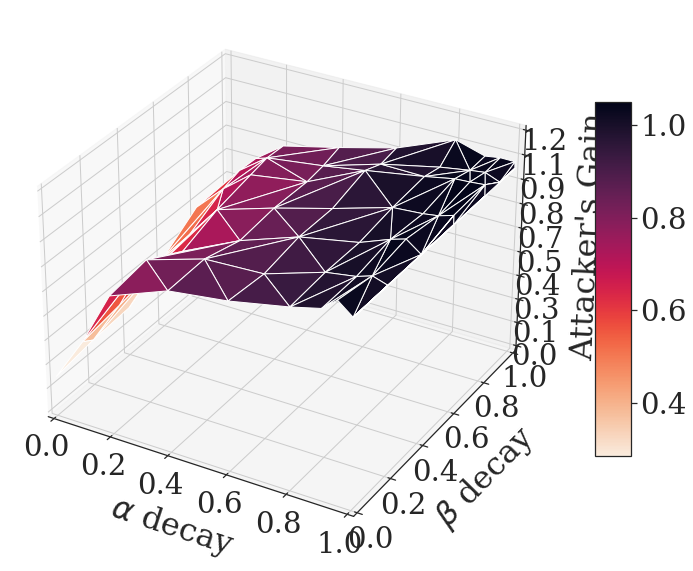

In [32]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
set_style()

#x = np.linspace(-4*np.pi,4*np.pi,50)
#y = np.linspace(-4*np.pi,4*np.pi,50)
# = x**2 + y**2

# Plot the surface.
surf = ax.plot_trisurf(x, y, z,  cmap='rocket_r',)

# Customize the z axis.
ax.set_zlim(0, 1.2)
ax.set_xlim(0, 1.0)
ax.set_ylim(0, 1.0)

ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.1f}')
# Add a color bar which maps values to colors.
fig.colorbar(surf,shrink=0.65, aspect=10)
#ax.view_init(30, 30)


# Set label for x-axis 
ax.set_xlabel( "\n" +  "$\\alpha$ decay", linespacing=2) 
# Set label for y-axis 
ax.set_ylabel( "\n" +  "$\\beta$ decay", linespacing=2) 
ax.yaxis.set_label_coords(.9, .1)
ax.set_zlabel( "\n" +  "Attacker's Gain", linespacing=2) 
# plt.savefig('alpha_beta_cumm.pdf', dpi=500, bbox_inches='tight');
plt.show()



In [22]:
df2

,alpha,theta,gamma,rep_alg,mad,sad,mrd,srd
0,0.100,0.0,0.0,pht,0.000512,0.230577,0.435532,195.989365
1,0.100,0.0,0.2,pht,0.000607,0.272988,0.470253,211.614055
2,0.100,0.0,0.4,pht,0.000710,0.319713,0.511783,230.302395
3,0.100,0.0,0.6,pht,0.000724,0.325731,0.545808,245.613661
4,0.100,0.0,0.8,pht,0.000791,0.355983,0.599234,269.655307
...,...,...,...,...,...,...,...,...
499,0.001,0.0,0.4,ppr,0.000157,0.072809,0.280344,129.799138
500,0.001,0.0,0.6,ppr,0.000269,0.124699,0.360836,167.067285
501,0.001,0.0,0.8,ppr,0.000356,0.164956,0.487227,225.586283
502,0.001,0.0,0.9,ppr,0.000396,0.183292,0.532032,246.330946


In [300]:
df2.to_csv('informativeness.csv')

In [246]:
theta

0.0

In [267]:
gtv_real_copy = ground_truth_values.copy()

In [269]:
gtv_norm_copy = {}
gtv_norm_copy['pht'] = normalize(ground_truth_values['pht'])
gtv_norm_copy['ppr'] = normalize(ground_truth_values['ppr'])

In [223]:
gtv_real = {}
gtv_norm = {}

In [229]:
gtv_real[theta] = ground_truth_values.copy()

In [230]:
gtv_norm[theta] = {}
for r in ['pht', 'ppr']:
    gtv_norm[theta][r] = normalize(ground_truth_values[r])

In [270]:
vals = []

for k,v in gtv_norm[0.0]['pht'].items():
    vals.append(abs(v - n_vals.get(k, 0)) / max(v, n_vals.get(k, 0)))
print(np.mean(vals), np.max(vals), np.sum(vals))


0.19156431970009868 1.0 84.47986498774353


In [262]:
ground_truth_values['pht'][140799]

KeyError: 0

In [261]:
gtv_real[0.0]['pht'][140799]

4.613099483786722

In [257]:
gtv_real[0.0]['pht'][140799]

4.613099483786722

In [253]:
mse

1.18891320372082e-06

In [ ]:
# Total time
end_w = 50
eps = 10**(-6)

num_seed_connections = 10

for rep_alg in ['pht', 'ppr']:    
    for theta in [1.0]:
        for gamma in [1.0]:
            for decay_p in [1.0]:
                # 0. Select initial seeds: Boostrap Period
                G = G_t[0].copy()
                score  = {i: G.in_degree(i, weight='weight') for i in G.nodes()}
                for k,v in score.items():
                    G.add_edge(0, k, weight=v)
                # Reputation and Data Values
                seed_node = 0
                rep_vals = defaultdict(float)
                gains = []
                for w in range(end_w):
                    # Calculate the reputation with all decays 
                    rep_alg_func = alg_func[rep_alg]
                    rep_alg_func(G, seed_node, rep_vals, decay_p, theta, gamma)
                    # Calculate gain
                    score = {k:v for k,v in rep_vals.items() if v > eps}
                    # Epoch decay on weights
                    for u,v in G.edges():
                        G[u][v]['weight'] *= theta
                        if G[u][v]['weight'] < cut_eps:
                            G.remove_edge(u, v)
                    # Add new edges to the graph
                    for f,t,data in G_t[w].edges(data=True):
                        if (f,t) in G.edges():
                            G[f][t]['weight'] += data['weight']
                        else:
                            G.add_edge(f, t, weight=data['weight'])
                    # Update the seed connections 
                    selected_seed_connections = sorted(score.items(), key=lambda x: x[1], reverse=True)[:num_seed_connections]
                    for k,v in selected_seed_connections:
                        G.add_edge(0, k, weight=10)                        
                i_25 = int(len(gains) * 0.25)
                i_50 = int(len(gains) * 0.5)
                i_75 = int(len(gains) * 0.75)
                i_100 = int(len(gains) - 1)
                df2 = df2.append({'num_syb': num_syb, 
                        'gain_0':  gains[0], 
                        'gain_25': gains[i_25], 
                        'gain_50': gains[i_50], 
                        'gain_75': gains[i_75],
                        'gain_100': gains[i_100], 
                        'alpha': (1-decay_p),
                        'theta': theta,
                        'gamma': gamma,
                        'rep_alg': rep_alg,
                        }, ignore_index=True)
                print('Finished with {}'.format(decay_p))
            print('Finished with {}'.format(gamma))
        print('Finished with {}'.format(theta))
    
# Epoch Decay: theta


In [213]:
df2.to_csv('full_exper_2.csv')

In [200]:
df2[(df2['theta'] == 1.) & (df2['gamma'] == 1.)]

,num_syb,gain_0,gain_25,gain_50,gain_75,gain_100,alpha,theta,gamma,rep_alg
88,1.0,0.052579,0.378252,0.520527,0.609404,0.627821,0.80,1.0,1.0,pmf
89,50.0,0.396889,6.043617,7.352099,7.540415,7.472467,0.80,1.0,1.0,pmf
90,1.0,0.077451,0.427042,0.612517,0.728879,0.773798,0.60,1.0,1.0,pmf
91,50.0,0.900741,8.230935,10.819074,11.534682,11.734204,0.60,1.0,1.0,pmf
92,1.0,0.109868,0.520324,0.755434,0.910008,0.988665,0.40,1.0,1.0,pmf
93,50.0,1.575998,11.075830,14.638651,15.616195,16.008877,0.40,1.0,1.0,pmf
94,1.0,0.129515,0.578173,0.867810,1.057427,1.170205,0.20,1.0,1.0,pmf
95,50.0,2.454199,13.898528,18.388047,19.616141,20.207282,0.20,1.0,1.0,pmf
96,1.0,0.138601,0.616522,0.930998,1.137840,1.274988,0.05,1.0,1.0,pmf
97,50.0,2.835891,15.428279,20.843700,22.379600,23.141415,0.05,1.0,1.0,pmf


In [197]:
df2[df2['theta'] == 0.75]

,num_syb,gain_0,gain_25,gain_50,gain_75,gain_100,alpha,theta,gamma,rep_alg
104,1.0,0.010198,0.043608,0.058779,0.062329,0.061096,0.8,0.75,1.00,pht
105,50.0,0.015330,0.070110,0.098830,0.121712,0.138980,0.8,0.75,1.00,pht
106,1.0,0.074996,0.302736,0.377197,0.392703,0.387458,0.2,0.75,1.00,pht
107,50.0,0.207407,1.096353,1.414371,1.586952,1.700385,0.2,0.75,1.00,pht
108,1.0,0.000022,0.000249,0.000477,0.000581,0.000581,0.8,0.75,0.01,pht
109,50.0,0.000093,0.000863,0.001195,0.001229,0.001339,0.8,0.75,0.01,pht
110,1.0,0.000711,0.002778,0.003522,0.003658,0.003651,0.2,0.75,0.01,pht
111,50.0,0.001981,0.009351,0.012061,0.013439,0.014338,0.2,0.75,0.01,pht
144,1.0,0.002202,0.036736,0.052788,0.057303,0.057419,0.8,0.75,1.00,ppr
145,50.0,0.010881,0.067490,0.100125,0.116574,0.128242,0.8,0.75,1.00,ppr


In [179]:
sum([rewards.get(attacker_node*2+i, 0) for i in range(total_syb)]) 

54974.97003203991

In [133]:
df2

,num_syb,gain_0,gain_25,gain_50,gain_75,gain_100,alpha,theta,gamma,rep_alg
0,1.0,0.003609,0.039768,0.053297,0.090601,0.115392,0.8,1.0,0.20,pht
1,50.0,0.002510,0.022078,0.033258,0.038025,0.042991,0.8,1.0,0.20,pht
2,1.0,0.010375,0.030755,0.081962,0.123225,0.158039,0.6,1.0,0.20,pht
3,50.0,0.016149,0.051161,0.074125,0.088710,0.114145,0.6,1.0,0.20,pht
4,1.0,0.018034,0.098358,0.178836,0.284550,0.344097,0.4,1.0,0.20,pht
5,50.0,0.030577,0.106475,0.186993,0.249667,0.280013,0.4,1.0,0.20,pht
6,1.0,0.030558,0.301716,0.477844,0.583056,0.656580,0.2,1.0,0.20,pht
7,50.0,0.064645,0.423590,0.751337,1.034387,1.337082,0.2,1.0,0.20,pht
8,1.0,0.000986,0.019737,0.017840,0.032036,0.039610,0.8,1.0,0.10,pht
9,50.0,0.004659,0.008062,0.011019,0.013137,0.014477,0.8,1.0,0.10,pht


In [134]:
df2.to_csv('exp_with_fixed_gamma.csv')

In [85]:
sorted(rewards.items(), key=lambda x: x[1], reverse=True)

[(140799, 8593.663704755954),
 (141429, 3234.631734859039),
 (142117, 2680.9617993889565),
 (141627, 1892.289091445653),
 (140820, 1860.343326164415),
 (142079, 1478.429602838717),
 (141701, 1407.1004451020906),
 (140397, 1364.179034994765),
 (141798, 1351.0849957600253),
 (140557, 1224.89251342836),
 (140869, 1175.6332912286753),
 (140957, 1136.740297967511),
 (141586, 997.1761924626345),
 (142258, 992.2030872657327),
 (142141, 991.4645430054493),
 (141821, 911.9485645210559),
 (140433, 784.2130263226934),
 (140904, 724.1975341270587),
 (140571, 677.2060820320085),
 (140860, 649.611841639523),
 (141957, 581.6054198651958),
 (140401, 559.7002255902074),
 (141648, 559.2699978812577),
 (142271, 475.546900335661),
 (142377, 406.62256631776825),
 (141043, 357.0011091615008),
 (142238, 342.8102213991092),
 (141389, 327.3099938601355),
 (141362, 326.7519360243608),
 (140836, 322.0885170082688),
 (140514, 310.886682924666),
 (141945, 307.50772422182),
 (142378, 305.30328066677305),
 (141291, 

In [74]:
rep_vals[282872]

0.020273391616490936

In [73]:
score

{282908: 6.510416666666667e-05,
 282871: 0.010992164843360328,
 282872: 0.020273391616490936,
 282873: 0.026374362169973516,
 282874: 0.02107799557177973,
 282875: 0.028951800219479032,
 282876: 0.03448804766592538,
 282877: 0.04571408981617098,
 282878: 0.04891592838623347,
 282879: 0.04615926246148681,
 282880: 0.058687835291889104,
 282881: 0.06630217359929663,
 282882: 0.07442349906725158,
 282883: 0.07625364774394704,
 282884: 0.07251874141170499,
 282885: 0.07612965029527706,
 282886: 0.08306231198275546,
 282887: 0.0794288099543654,
 282888: 0.0801202108657585,
 282889: 0.0631382774236282,
 282890: 0.04737997538662439,
 282891: 0.04381840671275603,
 282892: 0.036547035570893484,
 282893: 0.027794411088636273,
 282894: 0.017677304992391778,
 282895: 0.013470900460002136,
 282896: 0.011326141441489197,
 282897: 0.013163153003069599,
 282898: 0.0008029645994566434,
 282899: 0.00059433803536193,
 282900: 0.0005169864712672169,
 282901: 0.00016695052561747296,
 282902: 0.000142455730

In [65]:
df2

,num_syb,gain_0,gain_25,gain_50,gain_75,gain_100,alpha,theta,gamma,rep_alg
0,50.0,0.019489,0.064515,0.102627,0.143751,0.171412,0.4,1.0,0.1,pht
1,50.0,0.029538,0.144289,0.355026,0.679895,0.858605,0.4,0.9,0.1,pht
2,50.0,0.033231,0.645085,1.637432,2.300099,2.569006,0.4,0.8,0.1,pht
3,50.0,0.071155,2.025227,2.816605,2.809292,2.827476,0.4,0.5,0.1,pht
4,50.0,0.086427,2.712383,2.942688,2.995304,3.187006,0.4,0.2,0.1,pht
5,50.0,0.016209,0.065361,0.099932,0.128239,0.148757,0.4,1.0,0.1,ppr
6,50.0,0.021745,0.145166,0.296148,0.536252,0.745913,0.4,0.9,0.1,ppr
7,50.0,0.031508,0.343696,1.008542,1.538685,1.721433,0.4,0.8,0.1,ppr
8,50.0,0.052252,1.335236,1.873888,2.043249,2.009580,0.4,0.5,0.1,ppr
9,50.0,0.060036,1.931565,1.988110,1.999122,2.026937,0.4,0.2,0.1,ppr


In [52]:
gains

[0.0840204717047782,
 0.5441070324130122,
 2.04058133410856,
 3.8749549888640114,
 6.0288146269541185,
 10.728648614661491,
 20.258097417983933,
 40.41646528647062,
 67.1712358927405,
 137.51952671485296,
 89.91491391735781,
 195.14386017128896,
 63.8449327185811,
 99.20917659284255,
 390.2970677245838,
 247.9532673821184,
 513.7640258561705,
 1033.0948414004988,
 508.94790340339193,
 2557.1948943029834,
 12753.961767199537,
 64274.17788743765,
 322214.471073217,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [57]:
df2

,num_syb,gain_0,gain_25,gain_50,gain_75,gain_100,alpha,theta,gamma,rep_alg
0,50.0,0.177505,50.311660,515.413291,34726.811355,0.000000,0.4,0.2,0.2,pht
1,50.0,0.084020,40.416465,247.953267,322214.471073,0.000000,0.4,0.2,0.1,pht
2,50.0,0.028158,0.187148,0.409843,0.598170,0.738176,0.4,1.0,0.2,pht
3,50.0,0.015306,0.123465,0.252038,0.381478,0.464114,0.4,1.0,0.1,pht


In [35]:
df.to_csv('exper_with_gamma.csv')

In [48]:
df[df['rep_alg'] == 'pht']

,num_syb,gain_0,gain_25,gain_50,gain_75,gain_100,alpha,theta,gamma,rep_alg
0,1.0,0.011670,0.099671,0.143211,0.162440,0.170650,0.4,1.0,0.75,pht
1,50.0,0.015527,0.155614,0.252609,0.308813,0.359828,0.4,1.0,0.75,pht
2,1.0,0.009456,0.097973,0.144566,0.161029,0.173069,0.4,1.0,0.50,pht
3,50.0,0.010100,0.136176,0.230940,0.284856,0.317835,0.4,1.0,0.50,pht
4,1.0,0.003589,0.090376,0.140123,0.161543,0.168428,0.4,1.0,0.25,pht
5,50.0,0.006285,0.107937,0.180879,0.231572,0.258134,0.4,1.0,0.25,pht
6,1.0,0.002306,0.080003,0.119351,0.135888,0.143149,0.4,1.0,0.10,pht
7,50.0,0.002337,0.037942,0.088433,0.121618,0.144687,0.4,1.0,0.10,pht
8,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.4,1.0,0.00,pht
9,50.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.4,1.0,0.00,pht


In [38]:
end_w = 50

G = G_t[0].copy()
score  = {i: G.in_degree(i, weight='weight') for i in G.nodes()}
# Reputation and Data Values
seed_node = 0
rep_vals = defaultdict(float)

w = 0
# Initial reputation calculation 
G = G_t[w].copy()
for k,v in score.items():
    G.add_edge(0, k, weight=v)

G.add_edge(140799, 20, weight=20)

pht_cut(G, seed_node, rep_vals, 0.6, 0.2, 0.5)




In [39]:
rep_vals

defaultdict(float,
            {141701: 0.04024496937882764,
             141957: 0.04199475065616798,
             140557: 0.017497812773403322,
             141520: 0.01137357830271216,
             142176: 0.00699912510936133,
             142117: 0.1714785651793526,
             141798: 0.1163604549431321,
             140799: 0.32195975503062113,
             140591: 0.0,
             141362: 0.00699912510936133,
             141747: 0.0,
             142258: 0.0,
             141429: 0.03412073490813648,
             140860: 0.0752405949256343,
             141821: 0.03937007874015748,
             142271: 0.06824146981627296,
             20: 0.045909849749582635})

In [23]:
rand = r.random_walks
with_condition = True
threshold = 1.0
s = seed_node

In [24]:
for k in G.nodes():
    if rand.coleadings[k]:
        print(k, rand.get_number_of_hits(s, k), max(rand.coleadings[k].values()))

140557 40 25
140799 612 232
140860 150 33
141821 83 63
141701 109 80
141798 263 157
141362 14 6
142117 323 127
141957 116 58
142271 150 80
141429 80 38
141520 28 16
142176 13 8
20 342 342


defaultdict(int,
            {141821: 142,
             141701: 173,
             140799: 393,
             142117: 235,
             141798: 314,
             142271: 75,
             141957: 176,
             140557: 39,
             141429: 79,
             142176: 8,
             141362: 7,
             141520: 18})

In [563]:
rand.get_number_of_hits(s, 140799)

609

In [561]:
new_vals = {}
for g in G.nodes():
    max_neck = max(rand.coleadings[g].values()) if rand.coleadings[g] else 0
    full_condition = max_neck > 0 and (not with_condition 
                                        or max_neck >= threshold*rand.get_total_hits(s, g))
    if full_condition:
        print(max_neck, g, rand.get_total_hits(s, g))
        rw_prop = max_neck / rand.get_total_hits(s, g)
        new_vals[g] = max(rep_vals[g] *gamma*rw_prop, 0)

286 140557 116
2984 140799 1725
322 140860 228
491 141821 218
739 141701 300
1423 141798 674
17 141362 15
760 142117 651
610 141957 292
215 142271 212
334 141429 150
54 141520 39


In [560]:
new_vals

{140557: 0.0,
 140799: 0.0,
 140860: 0.0,
 141821: 0.0,
 141701: 0.0,
 141798: 0.0,
 141362: 0.0,
 142117: 0.0,
 141957: 0.0,
 142271: 0.0,
 141429: 0.0,
 141520: 0.0}

In [551]:
rep_vals

defaultdict(float,
            {140557: 0.03908554572271387,
             140799: 0.2245575221238938,
             140860: 0.084070796460177,
             141821: 0.06637168141592921,
             141701: 0.08333333333333333,
             141798: 0.14638643067846607,
             141362: 0.0055309734513274336,
             142117: 0.14343657817109146,
             141747: 0.0,
             141957: 0.08296460176991151,
             142271: 0.058997050147492625,
             141429: 0.045722713864306784,
             141520: 0.014011799410029498,
             142258: 0.0,
             140591: 0.0,
             142176: 0.0055309734513274336,
             0: 0.3687315634218289})

In [543]:
df

,num_syb,gain_0,gain_25,gain_50,gain_75,gain_100,alpha,theta,gamma,rep_alg
0,1.0,0.035380,0.133178,0.247781,0.283860,0.297989,0.05,1.0,1.0,pht
1,5.0,0.069653,0.320772,0.593680,0.703143,0.745371,0.05,1.0,1.0,pht
2,10.0,0.101153,0.484468,0.857577,1.029344,1.138606,0.05,1.0,1.0,pht
3,20.0,0.124586,0.605919,1.110348,1.411940,1.600808,0.05,1.0,1.0,pht
4,50.0,0.139207,0.793357,1.410041,1.861290,2.234245,0.05,1.0,1.0,pht
...,...,...,...,...,...,...,...,...,...,...
2155,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.95,0.0,0.0,ppr
2156,5.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.95,0.0,0.0,ppr
2157,10.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.95,0.0,0.0,ppr
2158,20.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.95,0.0,0.0,ppr


In [547]:
df2 = df[(df['gamma'] == 0.0)]
df2

,num_syb,gain_0,gain_25,gain_50,gain_75,gain_100,alpha,theta,gamma,rep_alg
150,1.0,0.0,0.0,0.0,0.0,0.0,0.05,1.0,0.0,pht
151,5.0,0.0,0.0,0.0,0.0,0.0,0.05,1.0,0.0,pht
152,10.0,0.0,0.0,0.0,0.0,0.0,0.05,1.0,0.0,pht
153,20.0,0.0,0.0,0.0,0.0,0.0,0.05,1.0,0.0,pht
154,50.0,0.0,0.0,0.0,0.0,0.0,0.05,1.0,0.0,pht
...,...,...,...,...,...,...,...,...,...,...
2155,1.0,0.0,0.0,0.0,0.0,0.0,0.95,0.0,0.0,ppr
2156,5.0,0.0,0.0,0.0,0.0,0.0,0.95,0.0,0.0,ppr
2157,10.0,0.0,0.0,0.0,0.0,0.0,0.95,0.0,0.0,ppr
2158,20.0,0.0,0.0,0.0,0.0,0.0,0.95,0.0,0.0,ppr


In [ ]:
import seaborn as sns

sns.lineplot(data=df2, x='gamma', y='gain', hue='decay_p', ci = 40, estimator='mean')

In [498]:
# With 1 Sybils
print(gains[-1]/ gains[0]) # Advantage gain over time 
print(gains[0])

1.1384918567178657
2.8833408567484455


In [478]:
# With 2  Sybils
print(gains[-1]/ gains[0]) # Advantage gain over time 
print(gains[0])

8.241125174606536
0.07312698776860053


In [480]:
# With 2  Sybils
print(gains[-1]/ gains[0]) # Advantage gain over time 
print(gains[0])

16.725621641176467
0.21566857120140653


In [481]:
0.21566857120140653 / 0.05088437842728046

4.238404356449423

In [440]:
# Calculate Gain of the attacker 
gains

[2.8646335421000093,
 5.6344895084657995,
 12.532088371008918,
 23.731887477261463,
 29.63205118049989,
 37.33409999660246,
 59.61438420841222,
 88.57533224150984,
 104.84436214753212,
 110.08830230061433,
 95.06479126005665,
 109.1664400692735,
 100.14443941816508,
 87.08944804622969,
 66.18355173102495,
 64.24514548299433,
 72.47773434922715,
 72.72440532471346,
 59.299926197767476,
 65.61563965163005,
 71.77626252381472,
 59.38719105987331,
 51.53826591352075,
 46.599147594862025,
 40.80500841140467,
 40.692994879241255,
 39.045268820774076,
 26.186667017217502,
 21.355814891741684,
 23.825799787725305]

In [407]:
for k,v in sorted(rep_vals.items(), key=lambda x: x[1], reverse=True)[:20]:
    print(k,id_to_user[str(k)],v)

140799 @LongForWisdom 8.54130946666104
141627 @hexonaut 3.2460021737748423
141429 @cyrus 3.0227426588876676
141031 @SebVentures 3.0166506472535652
140820 @MakerMan 3.005883915188721
140557 @Davidutro 2.8937267171117265
142079 @psychonaut 2.8635990196338597
142117 @rich.brown 2.8118645734635277
140587 @ElProgreso 2.7582289044542665
140957 @Planet_X 2.6032943659795316
140397 @Aaron_Bartsch 2.5861717590330664
141957 @mrabino1 2.1839319357473315
141701 @jernejml 2.1439536881620955
141945 @monet-supply 2.1423988468609205
140968 @Primoz 2.1305523293092343
142325 @ultraschuppi 2.1255511283072317
142141 @rune 2.045638846106539
140904 @NikKunkel 1.9946741942373127
140571 @Derek 1.9709956490505802
141648 @iammeeoh 1.9382153467900394


In [ ]:

for w in range(end_w):
    # Initial reputation calculation 
    G = G_t[w].copy()
    for k,w in score.items():
        G.add_edge(0, k, weight=w)
    # Calculate with Transitivity Decay: alpha and Diversity Decay: gamma
    simple_pht(G, seed_node, rep_vals, decay_p = decay_p)
    score = {k:v for k,v in rep_vals.items() if v > 0}
    if w % (end_w/10) == 0:
        print('Finished w = %d' % w)

# Epoch Decay: theta


In [384]:
# Pre-run the reputation 
rep_vals = defaultdict(float)
seed_punish = False

G = G_t[0]
num_seeds = 3 

score  = {i: G.in_degree(i)*G.out_degree(i) for i in G.nodes()}
sorted_score = sorted(score.items(), key=lambda x: x[1], reverse=True)
initial_seeds = [k for k,_ in sorted_score[:num_seeds]]
new_seeds = initial_seeds.copy()

for w in range(40):
    cur_seeds = []
    selected_seeds = 0
    G = G_t[w].copy()
    # 1. Select seeds based on gained reputation 
    cur_seeds = pick_seeds(new_seeds, num_seeds)

    # 2. Build auxiliary graph. Weights for indirect edges are change to proportional. 
    for seed_node in cur_seeds:
        # simple_maxflow(G, seed_node, rep_vals,)
        # simple_ppr(G, seed_node, rep_vals, decay_p = decay_p, use_weight= False)
        
        # aux_max_flow(G, seed_node, rep_vals, decay_p = decay_p)
        # 3. Seed punish
        if seed_punish:
            intro_rep = G.out_degree(seed_node, weight='weight')
            rep_vals[seed_node] -= intro_rep * seed_decay
            rep_vals[seed_node] = max(rep_vals[seed_node], 0)

    new_seeds = sorted(rep_vals.items(), key=lambda x: x[1], reverse=True)
    new_seeds = [k for k,_ in new_seeds]

seeds =  new_seeds[:10]


In [115]:
import pandas as pd
df = pd.DataFrame(columns=['active', 'passive', 'num_syb', 'weeks', 'decay_p'])

In [116]:
rep_vals = defaultdict(float)
old_rep_vals = []

num_seeds = 3

seed_decay = 0.1
seed_punish = False
attack_w = 20
syb_rep_gain = {}

contrib_decay_w = 8 # 2 mounts 
contrib_decay_val = 0
N = 30

for decay_p in [0.4, 0.6, 0.8]:
    for num_syb in [30, 20, 15, 10, 5, 4, 3, 2, 1, 0]:
        for total_weeks in range(1, 10):
            total_syb = 0
            rep_vals = defaultdict(float)
            new_seeds = seeds[:num_seeds]
            attacker_node = np.random.choice(G[new_seeds[0]])
            for w in range(40, 40 + total_weeks):
                G = G_t[w].copy()
                cur_seeds = []
                selected_seeds = 0
                # 1. Select seeds based on gained reputation 
                while selected_seeds < num_seeds:
                    for s in new_seeds:
                        if s in G:
                            cur_seeds.append(s)
                            selected_seeds += 1
                            if selected_seeds == num_seeds:
                                break
                    if selected_seeds != num_seeds:
                        print('Cannot find enough seeds!')
                        break
                if w >= attack_w and num_syb > 0:
                    total_syb += add_sybil_parallel_region(G, attacker_node, total_syb, num_syb)
                
                # 2. Build auxiliary graph. Weights for indirect edges are change to proportional. 
                for seed_node in cur_seeds:
                    # simple_maxflow(G, seed_node, rep_vals,)
                    # simple_ppr(G, seed_node, rep_vals, decay_p = decay_p, use_weight= False)
                    # simple_pht(G, seed_node, rep_vals, decay_p = decay_p, use_weight=False)
                    # aux_max_flow(G, seed_node, rep_vals, decay_p = decay_p)
                    # rep_alg = PersonalizedHittingTime(G, seed_node, 1000, reset_probability=1-decay_p)
                    rep_alg = PersonalizedHittingTime(G, seed_node, 1000, reset_probability=1-decay_p)
                    rep_with_cut(G, seed_node, rep_vals, rep_alg, gamma=0.0)
                    # 3. Seed punish
                    if seed_punish:
                        intro_rep = G.out_degree(seed_node, weight='weight')
                        rep_vals[seed_node] -= intro_rep * seed_decay
                        rep_vals[seed_node] = max(rep_vals[seed_node], 0)
                
                #old_rep_vals.append(rep_vals.copy())
                #if len(old_rep_vals) == contrib_decay_w:
                #    old_reps = old_rep_vals.pop(0)
                #    for k,v in old_reps.items():
                #        rep_vals[k] -= v * contrib_decay_val
                
                # Choose new seeds
                new_seeds = sorted(rep_vals.items(), key=lambda x: x[1], reverse=True)
                new_seeds = [k for k,_ in new_seeds]
            df = df.append({'active': sum([rep_vals[attacker_node*2 + i] for i in range(total_syb)]), 'passive':  rep_vals[attacker_node], 'num_syb': num_syb, 'weeks': total_weeks, 'decay_p': decay_p}, ignore_index=True)
            if num_syb % 5 == 0:
                print("Processed {} our of {}".format(num_syb, N))
    print('--- Finished {} ---'.format(decay_p))
        

Processed 30 our of 30
Processed 30 our of 30
Processed 30 our of 30
Processed 30 our of 30
Processed 30 our of 30
Processed 30 our of 30
Processed 30 our of 30
Processed 30 our of 30
Processed 30 our of 30
Processed 20 our of 30
Processed 20 our of 30
Processed 20 our of 30
Processed 20 our of 30
Processed 20 our of 30
Processed 20 our of 30
Processed 20 our of 30
Processed 20 our of 30
Processed 20 our of 30
Processed 15 our of 30
Processed 15 our of 30
Processed 15 our of 30
Processed 15 our of 30
Processed 15 our of 30
Processed 15 our of 30
Processed 15 our of 30
Processed 15 our of 30
Processed 15 our of 30
Processed 10 our of 30
Processed 10 our of 30
Processed 10 our of 30
Processed 10 our of 30
Processed 10 our of 30
Processed 10 our of 30
Processed 10 our of 30
Processed 10 our of 30
Processed 10 our of 30
Processed 5 our of 30
Processed 5 our of 30
Processed 5 our of 30
Processed 5 our of 30
Processed 5 our of 30
Processed 5 our of 30
Processed 5 our of 30
Processed 5 our of

In [385]:
def reputation_cut_experiment(alg, alg_label:str,df: pd.DataFrame, syb_attack_func, num_exp:int = 10, **kwargs):
    for decay_p in [0.05, 0.2, 0.4, 0.6, 0.8, 0.95]:
        for _ in range(num_exp):
            total_syb = 0
            rep_vals = defaultdict(float)
            new_seeds = seeds[:num_seeds]
            num_syb = 5
            total_syb = 0
            # Choose a random week after 40 
            w = np.random.randint(40, 150)
            G = G_t[w].copy()
            cur_seeds = []
            selected_seeds = 0

            # 0. Add Seed node and connect

            # 1. Select seeds based on gained reputation 
            while selected_seeds < num_seeds:
                for s in new_seeds:
                    if s in G:
                        cur_seeds.append(s)
                        selected_seeds += 1
                        if selected_seeds == num_seeds:
                            break
                if selected_seeds != num_seeds:
                    # Find other seeds - random? 
                    other_seeds = np.random.choice(G.nodes(), num_seeds - selected_seeds)
                    cur_seeds.extend(other_seeds)
            # Add Sybil Region
            attacker_node = np.random.choice(G.nodes())
            while attacker_node in cur_seeds or G.in_degree(attacker_node) == 0:
                attacker_node = np.random.choice(G.nodes())

            if num_syb > 0:
                total_syb += syb_attack_func(G, attacker_node, total_syb, num_syb)

            # 2. Calculate reputation 
            for seed_node in cur_seeds:
                alg(G, seed_node, rep_vals, decay_p = decay_p, **kwargs)
                # 3. Seed punish
                if seed_punish:
                    intro_rep = G.out_degree(seed_node, weight='weight')
                    rep_vals[seed_node] -= intro_rep * seed_decay
                    rep_vals[seed_node] = max(rep_vals[seed_node], 0)
            # Choose new seeds
            new_seeds = sorted(rep_vals.items(), key=lambda x: x[1], reverse=True)
            new_seeds = [k for k,_ in new_seeds]
            df = df.append({'active': sum([rep_vals[attacker_node*2 + i] for i in range(total_syb)]),
                            'passive':  rep_vals[attacker_node], 
                            'num_syb': num_syb, 
                            'weeks': w, 
                            'decay_p': 1-decay_p,
                            'alg': alg_label
                            }, ignore_index=True)
        print('Finished experiments with decay_p {}'.format(decay_p))
    return df

In [386]:
df = pd.DataFrame(columns=['active', 'passive', 'num_syb', 'weeks', 'decay_p'])
for g in [1, 0.75, 0.5, 0.25, 0.0]:
    new_df = pd.DataFrame()
    new_df = reputation_cut_experiment(pht_cut, 'rep_cut_pht', new_df, add_sybil_path_region, num_exp=10, gamma=g)
    new_df['gamma'] = 1-g
    print('Finised Experiments with gamma = {}'.format(g))
    df = df.append(new_df, ignore_index=True)

Finished experiments with decay_p 0.05
Finished experiments with decay_p 0.2
Finished experiments with decay_p 0.4
Finished experiments with decay_p 0.6
Finished experiments with decay_p 0.8
Finished experiments with decay_p 0.95
Finised Experiments with gamma = 1
Finished experiments with decay_p 0.05
Finished experiments with decay_p 0.2
Finished experiments with decay_p 0.4
Finished experiments with decay_p 0.6
Finished experiments with decay_p 0.8
Finished experiments with decay_p 0.95
Finised Experiments with gamma = 0.75
Finished experiments with decay_p 0.05
Finished experiments with decay_p 0.2
Finished experiments with decay_p 0.4
Finished experiments with decay_p 0.6
Finished experiments with decay_p 0.8
Finished experiments with decay_p 0.95
Finised Experiments with gamma = 0.5
Finished experiments with decay_p 0.05
Finished experiments with decay_p 0.2
Finished experiments with decay_p 0.4
Finished experiments with decay_p 0.6
Finished experiments with decay_p 0.8
Finished 

In [388]:
df['gain'] = (df['active']) / df['passive']
# df
df2 = df.dropna()

In [243]:
df.to_csv('gamma_syb.csv')

In [250]:
df.to_csv('gamma_syb_neck_only.csv')

In [266]:
df2.to_csv('gamma_syb_neck_only_2.csv')

In [274]:
df3 = pd.read_csv('gamma_syb_neck_only_2.csv')

In [290]:
df3 = df3.append(df2, ignore_index=True)

<AxesSubplot:xlabel='gamma', ylabel='gain'>

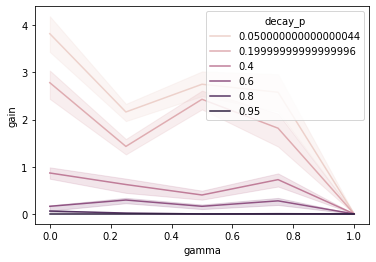

In [390]:
import seaborn as sns

sns.lineplot(data=df2, x='gamma', y='gain', hue='decay_p', ci = 40, estimator='mean')

<AxesSubplot:xlabel='gamma', ylabel='gain'>

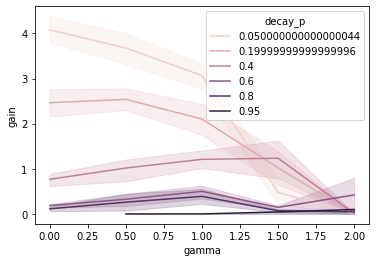

In [273]:
import seaborn as sns

sns.lineplot(data=df3, x='gamma', y='gain', hue='decay_p', ci=50)

In [172]:
df = pd.DataFrame(columns=['active', 'passive', 'num_syb', 'weeks', 'decay_p'])
df = reputation_cut_experiment(ppr_cut, 'rep_cut_ppr', df, add_sybil_path_region)
df = reputation_cut_experiment(simple_ppr, 'ppr', df, add_sybil_path_region)

--- Finished 40 ---
--- Finished 41 ---
--- Finished 42 ---
--- Finished 43 ---
--- Finished 44 ---
--- Finished 40 ---
--- Finished 41 ---
--- Finished 42 ---
--- Finished 43 ---
--- Finished 44 ---


,active,passive,num_syb,weeks,decay_p,alg,gain
0,0.046525,0.529052,5,40,0.40,rep_cut_ppr,0.087940
1,0.004099,0.026476,5,40,0.40,rep_cut_ppr,0.154823
2,0.007877,0.074215,5,40,0.40,rep_cut_ppr,0.106140
3,0.082699,0.262881,5,40,0.40,rep_cut_ppr,0.314588
4,0.021325,0.031566,5,40,0.40,rep_cut_ppr,0.675558
...,...,...,...,...,...,...,...
395,19.383635,5.296806,5,44,0.95,ppr,3.659495
396,26.898086,10.135507,5,44,0.95,ppr,2.653847
397,7.048318,1.459089,5,44,0.95,ppr,4.830628
398,19.545310,6.016506,5,44,0.95,ppr,3.248615


In [189]:
df.replace([np.inf], 0, inplace=True)

In [194]:
np.max(df.loc[(df['decay_p'] == 0.95) & (df['alg'] == 'rep_cut_ppr'), 'gain'])

5.201247460189953

In [199]:
df.to_csv('rep_cut_comp_ppr.csv')

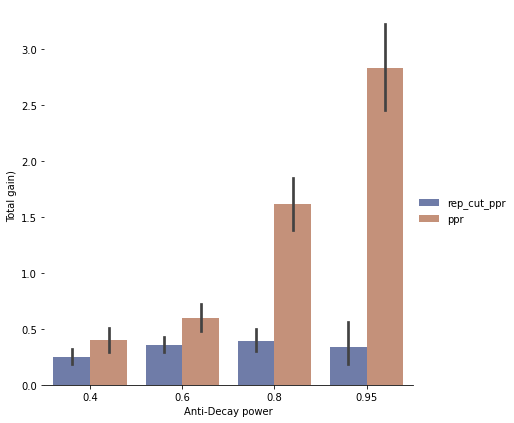

In [196]:
g = sns.catplot(data=df, kind='bar', x='decay_p', y='gain', hue='alg', palette="dark", alpha=.6, height=6)
g.despine(left=True)
g.set_axis_labels("$\alpha$ Decay", "Total gain)")
g.legend.set_title("")


In [131]:
df2 = df[(df['weeks'] == 4) & (df['decay_p'] > 0.4)]

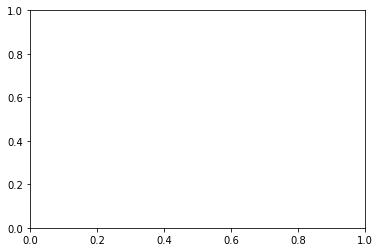

In [132]:
import seaborn as sns


# g.set(yscale='log')
# g_results.set(xticks=sample_count)
#g_results.set(xticklabels=sample_count)


## Passive Sybil Attack

In [25]:
rep_algs = {'ppr': PersonalizedPageRank, 'pht': PersonalizedHittingTime, 'pmf': MaxFlow}
rep_args = {'ppr': {'number_random_walks': 1000, 'reset_probability': 1 - decay_p}, 
            'pht': {'number_random_walks': 1000, 'reset_probability': 1 - decay_p}, 
            'pmf': {}}

In [26]:
# Calculate the deserved reputation 
deserved_rep = {}
rep_vals = {'ppr': defaultdict(float), 'pht': defaultdict(float), 'pmf': defaultdict(float)}
new_seeds = {'ppr': initial_seeds.copy(), 'pht': initial_seeds.copy(), 'pmf': initial_seeds.copy()}
cur_seeds = {}
new_nodes = set()
old_nodes = set()

rewards = {'ppr': defaultdict(float), 'pht': defaultdict(float), 'pmf': defaultdict(float)}
used_rep = {'ppr': defaultdict(float), 'pht': defaultdict(float), 'pmf': defaultdict(float)}


H_t = [G_t[i].copy() for i in range(max_l)]

for w in range(end_attack_w):
    G = H_t[w]
    # # 1. Pick seeds for reputation calculation 
    for r_n in rep_algs.keys():
        cur_seeds[r_n] = pick_seeds(new_seeds[r_n], num_seeds)
    # 2. Insert Attack edges 
    if w >= start_attack_w and w <= end_attack_w:
        # The attacker known the current seeds. 
        new_nodes = new_nodes | {g for g in G.nodes() if g not in old_nodes}
    else: 
        old_nodes = old_nodes | set(G.nodes())
    # 3. Insert Sybil edges 
    # 4. Update reputation
    for r_n in rep_algs.keys():
        for seed_node in cur_seeds[r_n]:    
            new_rep = agg_rep_update(G, seed_node, rep_algs[r_n], **rep_args[r_n])
            for k,v in new_rep.items():
                rep_vals[r_n][k] += v
        # 6. Choose new seeds: maximum reputation 
        new_seeds[r_n] = [k for k,_ in sorted(rep_vals[r_n].items(), key=lambda x: x[1], reverse=True)]
    # 7. Distribute the rewards 
    for r_n in rep_algs.keys():
        rep_sum = sum(rep_vals[r_n].values())
        for k,v in rep_vals[r_n].items():
            # rewards[r_n][k] += (v - used_rep[r_n][k]) * reward_per_w / num_seeds
            rewards[r_n][k] += (v / rep_sum) * reward_per_w
            used_rep[r_n][k] = rep_vals[r_n][k]
    


142079

In [100]:
G = G_t[45].copy() 

seed_node = 140799
attacker_node = np.random.choice(G[seed_node])

decay_p = 0.85

total_syb = 0
total_syb += add_sybil_parallel_region(G, attacker_node, total_syb, 10)
rep_vals = defaultdict(float)

rep_alg = PersonalizedHittingTime(G, seed_node, 1000, reset_probability=1-decay_p)
rep_with_cut(G, seed_node, rep_vals, rep_alg, gamma=-0.5)
print (sum([rep_vals[attacker_node*2 + i] for i in range(total_syb)]) / max(rep_vals[attacker_node], 1))


rep_vals = defaultdict(float)
simple_pht(G, seed_node, rep_vals, decay_p, use_weight=False)
print (sum([rep_vals[attacker_node*2 + i] for i in range(total_syb)]) / max(rep_vals[attacker_node], 1))


0.0015793189915621754
0.030742049469964665


In [61]:
sum([rep_vals[attacker_node*2 + i] for i in range(total_syb)]) / max(rep_vals[attacker_node], 1)

0.0002876755059903514

In [59]:
sum([rep_vals[attacker_node*2 + i] for i in range(total_syb)]) / max(rep_vals[attacker_node], 1)

0.0011342155009451797

In [57]:
sum([rep_vals[attacker_node*2 + i] for i in range(total_syb)]) / max(rep_vals[attacker_node], 1)

0.0

0.657560950585459

0.012697538562874897

In [18]:
sum([rep_vals[attacker_node*2 + i] for i in range(total_syb)]) / rep_vals[attacker_node]

1.2100840336134455

In [13]:
sum([rep_vals[attacker_node*2 + i] for i in range(total_syb)]) / rep_vals[attacker_node]

0.1381312337832369

In [8]:
G.in_edges(284242)

InEdgeDataView([(142117, 284242)])

In [10]:
rep_alg.random_walks.coleadings[284242], rep_alg.random_walks.get_number_of_hits(seed_node, 284242)

(defaultdict(int,
             {142117: 14,
              141627: 8,
              284238: 1,
              284239: 1,
              140571: 1,
              141362: 3,
              284236: 1,
              141269: 1,
              140968: 1,
              140904: 1,
              142079: 1,
              141174: 1}),
 11)

In [27]:
attacker_node = 140799
deserved_rewards = {r_n:rewards[r_n][attacker_node] for r_n in rep_algs.keys()}

In [28]:
rep_vals = {'ppr': defaultdict(float), 'pht': defaultdict(float), 'pmf': defaultdict(float)}
new_seeds = {'ppr': initial_seeds.copy(), 'pht': initial_seeds.copy(), 'pmf': initial_seeds.copy()}
cur_seeds = {}

H_t = [G_t[i].copy() for i in range(max_l)]

rewards = {'ppr': defaultdict(float), 'pht': defaultdict(float), 'pmf': defaultdict(float)}
used_rep = {'ppr': defaultdict(float), 'pht': defaultdict(float), 'pmf': defaultdict(float)}

syb_count = 0

for w in range(max_l):
    G = H_t[w]
    # # 1. Pick seeds for reputation calculation 
    for r_n in rep_algs.keys():
        cur_seeds[r_n] = pick_seeds(new_seeds[r_n], num_seeds)
    # 2. Insert Attack edges 
    # We mimic the attack edges as a real user - attacker_node
    # 3. Insert Sybil edges
    if w >= start_attack_w and w <= end_attack_w:
        a = attacker_node*2 + syb_count
        G.add_edge(attacker_node, a, weight=weight_attack_edges)
        # G.add_edge(a, attacker_node, weight=weight_attack_edges)
        for k in range(1, 10):
            G.add_edge(a+k, a + k + 1, weight=weight_attack_edges)
            # G.add_edge(a + k + 1, a + k, weight=weight_attack_edges)
        syb_count += 10
    # 4. Update reputation
    for r_n in rep_algs.keys():
        for seed_node in cur_seeds[r_n]:    
            new_rep = agg_rep_update(G, seed_node, rep_algs[r_n], **rep_args[r_n])
            for k,v in new_rep.items():
                rep_vals[r_n][k] += v
            # 5. Optional seed punish
            if seed_decay:
                rep_vals[r_n][seed_node] *= seed_decay_p
        # 6. Choose new seeds: maximum reputation 
        new_seeds[r_n] = [k for k,_ in sorted(rep_vals[r_n].items(), key=lambda x: x[1], reverse=True)]
    # 7. Distribute the rewards 
    for r_n in rep_algs.keys():
        rep_sum = sum(rep_vals[r_n].values())
        for k,v in rep_vals[r_n].items():
            # rewards[r_n][k] += (v - used_rep[r_n][k]) * reward_per_w / num_seeds
            rewards[r_n][k] += (v / rep_sum) * reward_per_w 
            used_rep[r_n][k] = rep_vals[r_n][k]


In [29]:
sum(rewards['ppr'].values()) 

79999.99999999994

In [30]:
rep_alg = 'ppr'
rewards[rep_alg][attacker_node] / deserved_rewards[rep_alg]

1.4135226136274182

In [31]:
rep_alg = 'pht'
rewards[rep_alg][attacker_node] / deserved_rewards[rep_alg]

1.4778968456239872

In [33]:
rep_alg = 'pmf'
rewards[rep_alg][attacker_node] / deserved_rewards[rep_alg]

1.354375273922803

In [34]:
rep_alg = 'pmf'
(sum([rewards[rep_alg][attacker_node*2+i] for i in range(syb_count)]) + rewards[rep_alg][attacker_node])  / deserved_rewards[rep_alg]

2.6081649900454678

In [35]:
rep_alg = 'pht'
(sum([rewards[rep_alg][attacker_node*2+i] for i in range(syb_count)]) + rewards[rep_alg][attacker_node])  / deserved_rewards[rep_alg]

2.556249479447597

In [36]:
rep_alg = 'ppr'
(sum([rewards[rep_alg][attacker_node*2+i] for i in range(syb_count)]) + rewards[rep_alg][attacker_node])  / deserved_rewards[rep_alg]

2.150150708325874

In [289]:
rep_alg = 'pht'
(sum([rep_vals[rep_alg][attacker_node*2+i] for i in range(syb_count)]) + rep_vals[rep_alg][attacker_node])  / deserved_rep[rep_alg]

KeyError: 'pht'

In [224]:
rep_alg = 'pmf'
(sum([rep_vals[rep_alg][attacker_node*2+i] for i in range(syb_count)]) + rep_vals[rep_alg][attacker_node])  / deserved_rep[rep_alg]

1.845723050009196

In [47]:
sorted(rep_vals['ppr'].items(), key=lambda x: x[1], reverse=True)[:10]

[(140799, 5.67325003604163),
 (141429, 3.7490466432844545),
 (140820, 3.681206877219496),
 (142079, 3.6185979168741196),
 (142117, 3.6138402338344005),
 (141627, 3.5571027952496475),
 (140397, 3.549948792423523),
 (140869, 3.5011648439566985),
 (140957, 3.4450984426805578),
 (140433, 3.1298624603557124)]

In [48]:
sorted(rep_vals['pht'].items(), key=lambda x: x[1], reverse=True)[:10]

[(140799, 4.744707178942078),
 (142079, 3.776979398347164),
 (140820, 3.7232587212692745),
 (141627, 3.6897183384048233),
 (141429, 3.598835733814079),
 (142117, 3.5261789929659955),
 (140869, 3.4590409405864007),
 (140397, 3.39027368089579),
 (140957, 3.3858486282993145),
 (142141, 3.344792391531886)]

In [49]:
sorted(rep_vals['pmf'].items(), key=lambda x: x[1], reverse=True)[:10]

[(141429, 3.21334108601447),
 (142117, 3.1318252048059176),
 (142079, 3.118224840264968),
 (142141, 3.1094687420077496),
 (141798, 3.0901714718476914),
 (140820, 3.0754017647102128),
 (140957, 3.07156733902436),
 (141701, 3.0499514246228356),
 (140799, 3.0441087777507465),
 (141627, 3.0276227928769512)]

In [51]:
rep_vals['pmf'][141429]

3.21334108601447